In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' # Gets rid of SettingWithCopy warnings
pd.options.display.float_format = '{:.1f}'.format # only print one decimal place

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

## Load Forecast Data

In [2]:
people = pd.read_csv('../data/forecast/people.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

people.shape

(26, 22)

In [3]:
projects = pd.read_csv('../data/forecast/projects.csv', 
                          index_col='id', 
                          parse_dates=['updated_at','start_date','end_date'],
                          infer_datetime_format=True)

projects.shape

(90, 12)

In [4]:
placeholders = pd.read_csv('../data/forecast/placeholders.csv', 
                          index_col='id',
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

placeholders.shape

(8, 5)

In [5]:
clients = pd.read_csv('../data/forecast/clients.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

clients.shape

(29, 5)

In [6]:
assignments = pd.read_csv('../data/forecast/assignments.csv', 
                          index_col='id', 
                          parse_dates=['start_date','end_date','updated_at'],
                          infer_datetime_format=True)

assignments['allocation'] = assignments['allocation']/(8*60*60)
assignments.shape

(177, 11)

## Functions to merge and display data on people's allocations

In [7]:
# Group the assignments by person
grouped_allocations = assignments.groupby(['person_id','project_id','start_date','end_date']).allocation.sum()

# Find the earliest and latest date in the data
date_range = pd.date_range(start=assignments['start_date'].min(),
                           end=assignments['end_date'].max(),
                           freq='D')


def get_person_name(person_id):
    """Get the full name of someone from their person_id"""
    return people.loc[person_id,'first_name'] + ' ' + people.loc[person_id, 'last_name']


def get_person_id(first_name, last_name=None):
    """Get the person_id of someone from their first_name and last_name."""
    if last_name is None:
        person_id = people.loc[(people['first_name']==first_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name)

    else:
        person_id = people.loc[(people['first_name']==first_name) & (people['last_name']==last_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name+' '+last_name)

    return person_id.index[0]


def get_project_name(project_id):
    """Get the name of a project from its project_id"""
    return projects.loc[project_id, 'name']


def select_date_range(df, start_date, end_date): 
    """Extract a range of dates from a dataframe with a datetime index, 
    then remove any columns which are left empty (full of zeros)."""
    mask = (df.index >= start_date) & (df.index <= end_date)
    df_slice = df.loc[mask]
    
    nonzero_cols = df_slice.columns[df_slice.sum()!=0]
    df_slice = df_slice[nonzero_cols]
        
    return df_slice


def get_person_allocations(person_id):
    """For one person, create a dataframe where the rows are days,
    the columns are projects, and the cell values are allocations
    as a fraction of an 8 hour day."""
    
    # check whether the person has any project assignments, i.e. whether the person
    # exists in the index (get_level_values to deal with MultiIndex)
    if person_id in grouped_allocations.index.get_level_values(0):
        # get the person's allocations
        person = grouped_allocations.loc[person_id]
        
        # unstack the MultiIndex
        person = person.reset_index()

        # Initialise dataframe to store results
        allocated_days = pd.DataFrame(index=date_range, columns=person.project_id.unique())
        allocated_days.fillna(0,inplace=True)

        # Loop over each project assignment
        for idx,row in person.iterrows():
            # Create the range of dates that this assignment corresponds to, with daily frequency
            dates = pd.date_range(start=row['start_date'], end=row['end_date'], freq='D')
            
            # Add the allocation to the corresponding project for the range of dates.
            allocated_days.loc[dates, row['project_id']] += row['allocation']

        # Add the person's name as a label - just nice for printing later.
        allocated_days.columns.name = get_person_name(person_id)
        
    else:
        # no projects, just make an empty dataframe..
        allocated_days = pd.DataFrame(index=date_range)
    
    return allocated_days


# dictionary containing each person's daily project allocations
people_allocations = {person_id: get_person_allocations(person_id) for person_id in people.index}    

# data frame containing each person's total daily allocation across all projects
people_totals = pd.DataFrame(index=date_range, columns=people.index)
for person_id in people_allocations.keys():
    people_totals[person_id] = people_allocations[person_id].sum(axis=1)
    

def plot_person_allocations(person_id, start_date, end_date):
    """Make a stacked area plot of a person's project allocations between
    a start date and an end date."""
    
    # get the person's project allocations
    df = people_allocations[person_id]
    
    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    # replace project_ids in column names with their project names
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # check whether there's anything to plot
    rows,cols = df.shape
    if rows>0 and cols>0:
        df = df.resample('W-MON').mean()

        # plot the data
        ax = plt.figure(figsize=(15,5)).gca()
        df.plot.area(ax=ax, linewidth=0)

        xlim = ax.get_xlim()
        plt.plot(xlim,[0.8, 0.8], 'k--', linewidth=3)
        plt.plot(xlim,[1, 1], 'k', linewidth=3)
        plt.xlim(xlim)
        plt.ylim([0, max([1, 1.1*df.sum(axis=1).max()])])

        plt.title(get_person_name(person_id))
        plt.ylabel('Proportion 8hr days')
        plt.xticks()
        plt.legend(title='',loc='best')
        plt.show()
        
    else:
        print('Nothing to plot.')


def highlight_allocations(df):
    """Function to conditionally style a data frame:
        Total allocations above 1.0 are highlighted red,
        above 0.8 orange, 0.8 yellow, and below 0.8 green.
        
        Individual project allocations are coloured blue when
        the person is active and grey when inactive on that project"""
    
    def highlight_tot(series):
        """function used to apply highlighting to the TOTAL column"""
        is_over = series>1.01
        is_marginal = (series>0.81) & (is_over==False)
        is_under = series<0.79

        style = []
        for i in range(len(series)):
            if is_over[i]:
                style.append('background-color: red')
            elif is_marginal[i]:
                style.append('background-color: orange')
            elif is_under[i]:
                style.append('background-color: lime')
            else:
                style.append('background-color: yellow')

        return style
    
    
    def highlight_active(series):
        """Function used to apply highlighting to all columns except the TOTAL column"""
        style=[]
        for i in range(len(series)):
            if series[i]>0:
                style.append('background-color: lightblue')
            else:
                style.append('background-color: dimgrey')
                
        return style
    
    # Apply the style. In order:
    #   - display percentages to nearest integer
    #   - centre align text
    #   - centre align and word wrap column names
    #   - conditional formatting for TOTAL column
    #   - conditional formatting for remaining columns
    return df.style.\
           format('{:.0%}').\
           set_properties(**{'text-align': 'center'}).\
           set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                       ('text-align','center')])]).\
           apply(highlight_active, subset=df.columns.drop('TOTAL')).\
           apply(highlight_tot, subset=['TOTAL'])


def table_person_allocations(person_id, start_date, end_date, freq='MS'):
    """Display a formatted table of a person's project allocations in a given
    date range, and with a certain date frequency. E.g. if freq='MS' each row
    will correspond to a month. 'D' for days, or 'W-MON' for weeks."""
    
    # extract the person's allocations, and replace ids with names
    df = people_allocations[person_id].copy()
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # add the person's total project assignment to the data frame
    df['TOTAL'] = people_totals[person_id]

    # slice the given date range from the dataframe
    df = select_date_range(df, start_date, end_date)
    
    # check there's something to display
    rows,cols = df.shape
    if rows>0 and cols>0:
        # resample the rows to the given date frequency
        df = df.resample(freq).mean()

        # change date format for prettier printing
        df = pd.DataFrame(df, index=df.index.strftime("%Y-%m-%d"))

        # display the table
        display(highlight_allocations(df))
        
    else:
        print('Nothing to print.')

## Show Someone's Project Assignment

Dropdown(description='Person:', index=18, options=('Amaani Hoddoon', 'Amber Raza', 'Angus Williams', 'Camila R…

DatePicker(value=datetime.datetime(2019, 1, 1, 0, 0), description='Start Date:')

DatePicker(value=datetime.datetime(2019, 12, 31, 0, 0), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

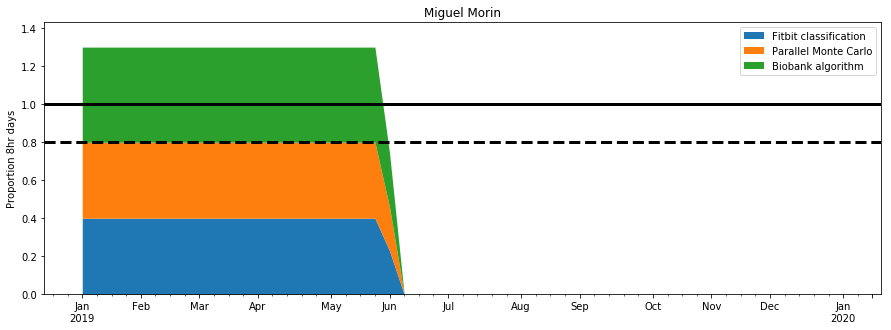

Miguel Morin,Fitbit classification,Parallel Monte Carlo,Biobank algorithm,TOTAL
2019-01-01,40%,40%,50%,130%
2019-02-01,40%,40%,50%,130%
2019-03-01,40%,40%,50%,130%
2019-04-01,40%,40%,50%,130%
2019-05-01,40%,40%,50%,130%
2019-06-01,0%,0%,0%,0%
2019-07-01,0%,0%,0%,0%
2019-08-01,0%,0%,0%,0%
2019-09-01,0%,0%,0%,0%
2019-10-01,0%,0%,0%,0%


In [8]:
# dropdown list to select a person
widg_person_select = widgets.Dropdown(options=sorted([get_person_name(person_id) for person_id in people.index]),
                                 description='Person:')

# date picker to choose a start date
widg_person_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime(2019,1,1),
                    disabled=False
                )

# date picker to choose an end date
widg_person_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime(2019,12,31),
                    disabled=False
                )

# radio buttons to choose the frequency of dates to display in the table
widg_person_freq = widgets.RadioButtons(
    options=['Monthly', 'Weekly', 'Daily'],
    value='Monthly',
    description='Frequency:',
    disabled=False
)



def widg_person_select_alloc(change):
    """Function called by widgets to update the person allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_person_select, widg_person_start, widg_person_end, widg_person_freq)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    names = widg_person_select.value.split()
    person_id = get_person_id(names[0], ' '.join(names[1:]))
    
    # get the selected dates
    start_date = pd.to_datetime(widg_person_start.value)
    end_date = pd.to_datetime(widg_person_end.value)
    
    # get the selected date frequency
    freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}
    freq = freq_dict[widg_person_freq.value]
    
    # plot the person allocations
    plot_person_allocations(person_id, start_date, end_date)
    
    # print the person allocations table
    table_person_allocations(person_id, start_date, end_date, freq)

# setup the event listeners
widg_person_select.observe(widg_person_select_alloc, names='value')
widg_person_start.observe(widg_person_select_alloc, names='value')
widg_person_end.observe(widg_person_select_alloc, names='value')
widg_person_freq.observe(widg_person_select_alloc, names='value')

# display the widgets
display(widg_person_select, widg_person_start, widg_person_end, widg_person_freq)

# show results with initial values
widg_person_select_alloc(None)

## Show Everyone's Total Project Allocation Over Time

In [9]:
def highlight_tot(series):
    """Function used to apply conditional formatting to cells based on their values.
    Currently: below 0.8=green, 0.8=yellow, above 0.8=orange, above 1.0=red."""
    is_over = series>1.01
    is_marginal = (series>0.81) & (is_over==False)
    is_under = series<0.79

    style = []
    for i in range(len(series)):
        if is_over[i]:
            style.append('background-color: red')
        elif is_marginal[i]:
            style.append('background-color: orange')
        elif is_under[i]:
            style.append('background-color: lime')
        else:
            style.append('background-color: yellow')

    return style


def table_team_allocations(change):
    """Function to display a table of each team member's (columns) allocation over time (rows).
    Change argument not used - just to have function with required format for widget.observe"""
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_team_start, widg_team_end, widg_team_freq)

    # initialise df
    df = people_totals.copy()

    # mask used to select date range of interest
    mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))

    # get the selected date frequency
    freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}
    freq = freq_dict[widg_team_freq.value]
    
    # extract slice of dates, and resample to selected frequency
    df = df[mask].resample(freq).mean()

    # replace person ids with names
    df.columns = [get_person_name(person_id) for person_id in df.columns]

    # format dates nicely
    if freq=='MS':
        df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))
    elif freq=='W-MON':
        df = pd.DataFrame(df, index=df.index.strftime("%d-%b-%Y"))
    else:
        df = pd.DataFrame(df, index=df.index.strftime("%Y-%m-%d"))

    # display the table with applied styling. In order:
    #   - sort columns by first name, display percentages to nearest integer
    #   - centre align text
    #   - centre align and word wrap column names
    #   - conditional formatting based on values
    display(df[sorted(df.columns)].style.format('{:.0%}').\
             set_properties(**{'text-align': 'center'}).\
             set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                           ('text-align','center')])]).\
             apply(highlight_tot)) 
    

# date picker to choose a start date
widg_team_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime(2019,1,1),
                    disabled=False
                )

# date picker to choose an end date
widg_team_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime(2019,12,31),
                    disabled=False
                )

# radio buttons to choose the frequency of dates to display in the table
widg_team_freq = widgets.RadioButtons(
    options=['Monthly', 'Weekly', 'Daily'],
    value='Monthly',
    description='Frequency:',
    disabled=False
)

# setup the event listeners
widg_team_start.observe(table_team_allocations, names='value')
widg_team_end.observe(table_team_allocations, names='value')
widg_team_freq.observe(table_team_allocations, names='value')

# display the widgets
display(widg_team_start, widg_team_end, widg_team_freq)

# show results with initial values
table_team_allocations(None)

DatePicker(value=datetime.date(2018, 11, 1), description='Start Date:')

DatePicker(value=datetime.datetime(2019, 12, 31, 0, 0), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

,Amaani Hoddoon,Amber Raza,Angus Williams,Camila Rangel Smith,David Beavan,Eric Daub,Evelina Gabasova,Giovanni Colavizza,Jack Roberts,James Geddes,James Hetherington,James Robinson,Jim Madge,Joel Dearden,Kasra Hosseini,Louise Bowler,Martin O'Reilly,May Yong,Miguel Morin,Nick Barlow,Oliver Strickson,Oscar Giles,Radka Jersakova,Sarah Gibson,Timothy Hobson,Tomas Lazauskas
Nov-2018,0%,0%,0%,80%,80%,0%,80%,80%,0%,80%,60%,80%,0%,0%,0%,80%,80%,80%,61%,80%,100%,0%,80%,80%,80%,80%
Dec-2018,0%,0%,0%,80%,80%,37%,80%,80%,0%,80%,76%,80%,57%,0%,0%,80%,70%,80%,130%,80%,109%,0%,80%,80%,80%,80%
Jan-2019,0%,0%,0%,80%,80%,72%,130%,80%,0%,80%,100%,80%,80%,0%,0%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Feb-2019,0%,0%,0%,80%,80%,80%,130%,80%,0%,80%,100%,80%,80%,0%,39%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Mar-2019,0%,0%,0%,80%,80%,75%,130%,80%,0%,80%,95%,75%,80%,0%,100%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Apr-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,40%,20%,80%,40%,0%,0%,90%,0%,40%,130%,80%,50%,0%,80%,40%,80%,40%
May-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,40%,20%,80%,0%,0%,0%,90%,0%,40%,130%,80%,50%,0%,80%,40%,80%,40%
Jun-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,80%,40%,80%,40%
Jul-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,80%,40%,80%,40%
Aug-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,40%,40%,80%,40%


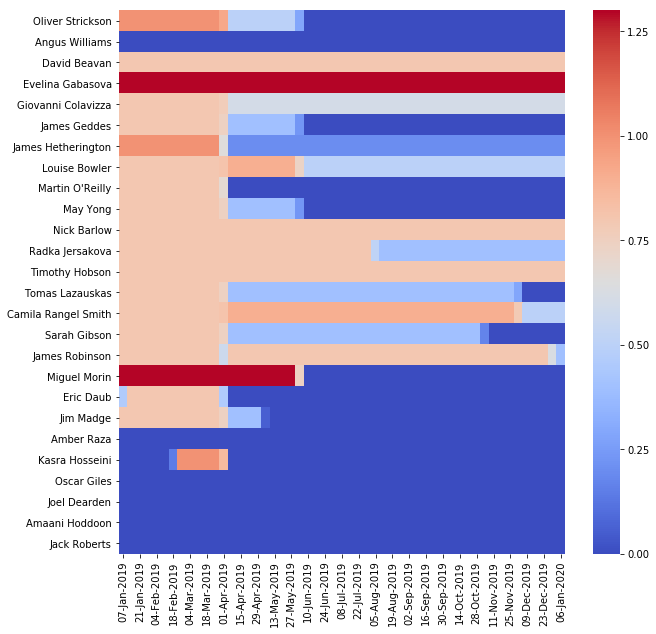

In [19]:
df = people_totals.copy()
mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))
df = df[mask].resample('W-MON').mean()
df.columns = [get_person_name(person_id) for person_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%d-%b-%Y"))

import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.T, cmap='coolwarm')

In [109]:
# get the person's project allocations

alloc_names = {}

start_date = pd.datetime(2018,11,1)
end_date = pd.datetime(2021,3,1)

project_names = set()

for person_id in people_allocations.keys():
    
    df = people_allocations[person_id].copy()

    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    rows,cols = df.shape
    
    if rows>0 and cols>0:    
        # replace project_ids in column names with their project names
        df.columns = [get_project_name(project_id) for project_id in df.columns]
        df.columns.name = get_person_name(person_id)
        [project_names.add(proj) for proj in df.columns]

        df = df.resample('MS').mean()
        
        df_ranked = pd.DataFrame(index=df.index, columns=['1st','2nd','3rd'])
                
        for date in df_ranked.index:
            
            sorted_projects = df.loc[date, df.loc[date]>0].sort_values(ascending=False)

            if len(sorted_projects)==0:
                df_ranked.loc[date, :] = ''
            
            else:
                df_ranked.loc[date,'1st'] = sorted_projects.index[0] + ' ({:.1f})'.format(sorted_projects.iloc[0])
                
                if len(sorted_projects)>1:
                    df_ranked.loc[date,'2nd'] = sorted_projects.index[1] + ' ({:.1f})'.format(sorted_projects.iloc[1])
                else:
                    df_ranked.loc[date, ['2nd','3rd']] = ''
                    
                if len(sorted_projects)>2:
                    proj_str = ''
                    for i in range(2, len(sorted_projects)):
                        proj_str = proj_str + sorted_projects.index[i] + ' ({:.1f})'.format(sorted_projects.iloc[i]) + ' / '
                    
                    df_ranked.loc[date,'3rd'] = proj_str[:-3]

                else:
                    df_ranked.loc[date, '3rd'] = ''
                    
        if df_ranked['2nd'].str.len().sum()==0:
            df_ranked.drop('2nd',axis=1,inplace=True)
        
        if df_ranked['3rd'].str.len().sum()==0:
            df_ranked.drop('3rd',axis=1,inplace=True)
        
        df_ranked = pd.DataFrame(df_ranked, df_ranked.index.strftime("%b-%Y"))
        
        alloc_names[get_person_name(person_id)] = df_ranked.T
        
alloc_names = pd.concat(alloc_names).sort_index()

alloc_names

Nov-2018  \
Camila Rangel Smith 1st                               AIDA (0.8)   
                    2nd                                            
David Beavan        1st               Living With Machines (0.8)   
Eric Daub           1st                                            
                    2nd                                            
Evelina Gabasova    1st                               NATS (0.4)   
                    2nd                           BA (IAG) (0.4)   
                    3rd                                            
Giovanni Colavizza  1st               Living With Machines (0.4)   
                    2nd                               AIDA (0.4)   
                    3rd                                            
James Geddes        1st                             Nocell (0.4)   
                    2nd                           BA (IAG) (0.2)   
                    3rd                               AIDA (0.2)   
James Hetherington  1st           SPF TPS Theme Management (0.5)   
                    2nd                  Training delivery (0.1)   
                    3rd                                            
James Robinson      1st                         Safe Haven (0.4)   
                    2nd                     Misinformation (0.4)   
                    3rd                                            
Jim Madge           1st                                            
                    2nd                                            
Kasra Hosseini      1st                                            
Louise Bowler       1st                     The Turing Way (0.4)   
                    2nd               AI for City Planning (0.4)   
Martin O'Reilly     1st                    Team management (0.4)   
                    2nd                     Misinformation (0.4)   
                    3rd                                            
May Yong            1st               AI for City Planning (0.4)   
                    2nd                               AIDA (0.4)   
Miguel Morin        1st                  Biobank algorithm (0.5)   
                    2nd               Parallel Monte Carlo (0.1)   
                    3rd              Fitbit classification (0.1)   
Nick Barlow         1st  Crypto Federated Learning (SHEEP) (0.4)   
                    2nd                               AIDA (0.4)   
Oliver Strickson    1st                               Maru (0.4)   
                    2nd            Sargasso (Intel Sparse) (0.4)   
                    3rd  Crypto Federated Learning (SHEEP) (0.2)   
Radka Jersakova     1st                           BA (IAG) (0.8)   
                    2nd                                            
Sarah Gibson        1st                        AIDA-Lloyds (0.4)   
                    2nd                     The Turing Way (0.4)   
Timothy Hobson      1st                               NATS (0.4)   
                    2nd               Living With Machines (0.4)   
Tomas Lazauskas     1st  Crypto Federated Learning (SHEEP) (0.4)   
                    2nd                    DetectorChecker (0.4)   

                                                              Dec-2018  \
Camila Rangel Smith 1st                          Knowledge Flows (0.4)   
                    2nd                                     AIDA (0.4)   
David Beavan        1st                     Living With Machines (0.8)   
Eric Daub           1st                        Probabilistic FEM (0.4)   
                    2nd                                                  
Evelina Gabasova    1st                                     NATS (0.4)   
                    2nd                                 BA (IAG) (0.4)   
                    3rd                                                  
Giovanni Colavizza  1st                     Living With Machines (0.4)   
                    2nd                                    GUARD (0.3)   
                    3rd                      

To do:

Same views for projects

Include placeholders/resources from other groups

Team total available resource plot/table

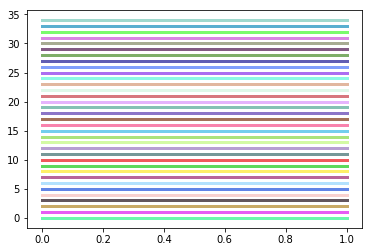

In [160]:
# https://gist.github.com/adewes/5884820
import random
from matplotlib.colors import rgb2hex

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = {}
for proj in project_names:
    colors[proj] = generate_new_color(colors.values(), pastel_factor=0.5)

for i,c in enumerate(colors.values()):
    plt.plot([0,1],[i,i],color=c,linewidth=3)


def highlight_proj(cell):
    cell = cell[:-6]
    if cell in project_names:
        return 'background-color: '+rgb2hex(colors[cell])
    else:
        return ''

styled_df = alloc_names.style.applymap(highlight_proj)
styled_df.to_excel('people_coloured_projects.xlsx')
display(styled_df)

